In [1]:
from pymol import cmd
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import py3Dmol

from openbabel import pybel

import sys, os, random
sys.path.insert(1, 'utilities/')

from utils import get_inplace_rmsd, get_scaffold_based_conformers, getbox

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

/home/shenwanxiang/anaconda3/envs/Jupyter_Dock/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/home/shenwanxiang/anaconda3/envs/Jupyter_Dock/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1112: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
os.chdir('test/Covalent_Docking/')

In [3]:
cmd.fetch(code='6ZRU',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Boceprevir',selection='resn U5G')
cmd.save(filename='6ZRU_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='Boceprevir_ref.sdf',format='sdf',selection='Boceprevir')
cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


In [4]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('6ZRU_clean.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open('Boceprevir_ref.sdf','r').read(),format='sdf')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

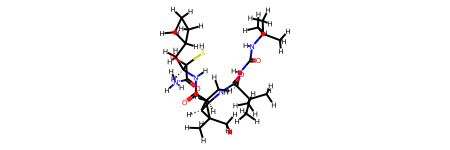

In [5]:
Boceprevir=Chem.MolFromSmiles('CC(C)(C)NC(=O)N[C@H](C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@@H](CC1CCC1)C(O)(S)C([NH3+])=O)C2(C)C)C(C)(C)C')
Boceprevir=Chem.AddHs(Boceprevir)
AllChem.EmbedMolecule(Boceprevir)
Boceprevir

In [6]:
writer=Chem.SDWriter('Boce_prep.sdf')
writer.write(Boceprevir)
writer.close()

In [8]:
get_scaffold_based_conformers(smiles='CC(C)(C)NC(=O)N[C@H](C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@@H](CC1CCC1)C(O)(S)C([NH3+])=O)C2(C)C)C(C)(C)C',
                              num_confs=100,rmsd_threshold=0.75, anchor='S_atom.sdf',
                              output='Confs.sdf')

OSError: File error: Bad input file S_atom.sdf

In [9]:
!../../bin/lepro_linux_x86 {'6ZRU_clean.pdb'}

os.rename('pro.pdb','6ZRU_clean_H.pdb')

In [10]:
confs=Chem.SDMolSupplier('Confs.sdf')

OSError: File error: Bad input file Confs.sdf

In [11]:
mol=confs[0]
for atom in mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()+1))

Draw.MolToImage(mol, size=(800,500))

NameError: name 'confs' is not defined

In [12]:
x_out=Chem.SDWriter('jfjdfj.sdf')
for c in confs:
    ed=AllChem.EditableMol(c)
    ed.RemoveAtom(27)
    x_out.write(ed.GetMol())
x_out.close()

NameError: name 'confs' is not defined

In [13]:
cmd.load(filename='6ZRU_clean_H.pdb',format='pdb',object='prot') #Not needed but as reference of the system
cmd.load(filename='Boceprevir_ref.sdf',format='sdf',object='lig')

center,size=getbox(selection='resn Cys and resid 145',extending=6.0,software='vina')
cmd.delete('all')
print(center)
print(size)

{'center_x': -14.353999614715576, 'center_y': -8.985999822616577, 'center_z': 13.019000053405762}
{'size_x': 15.6899995803833, 'size_y': 16.06399965286255, 'size_z': 15.068000793457031}


In [14]:

!../../bin/smina -r {'6ZRU_clean_H.pdb'} -l {'Boce_prep.sdf'} -o {'Smina.sdf'} --center_x {center['center_x']} --center_y {center['center_y']} --center_z {center['center_z']} --size_x {size['size_x']} --size_y {size['size_y']} --size_z {size['size_z']} --exhaustiveness 8 --num_modes 5 --custom_scoring {'Cov_ScoreFunction.txt'}

#candidates=Chem.SDWriter('Cans.sdf')
#results=Chem.SDMolSupplier('Smina.sdf')
#scaffold=Chem.SDMolSupplier('Adenine.sdf')[0]
#for res in results:
    #rmsd= get_inplace_rmsd (scaffold,res)
    #if float(res.GetProp('minimizedAffinity')) < 0:
        #res.SetProp('RMSDvsScaffold',str(rmsd))
        #candidates.write(res)
#candidates.close()

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
-100         atom_type_gaussian(t1=Sulfur,t2=Sulfur,o=0,_w=3,_c=8)
1.923        num_tors_div

Using random seed: 826621036

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol

In [15]:
!../../bin/smina --print_atom_types

#Name radius depth solvation volume covalent_radius xs_radius xs_hydrophobe xs_donor xs_acceptr ad_heteroatom
Hydrogen 1 0.02 0.00051 0 0.37 0 0 0 0 0
PolarHydrogen 1 0.02 0.00051 0 0.37 0 0 0 0 0
AliphaticCarbonXSHydrophobe 2 0.15 -0.00143 33.5103 0.77 1.9 1 0 0 0
AliphaticCarbonXSNonHydrophobe 2 0.15 -0.00143 33.5103 0.77 1.9 0 0 0 0
AromaticCarbonXSHydrophobe 2 0.15 -0.00052 33.5103 0.77 1.9 1 0 0 0
AromaticCarbonXSNonHydrophobe 2 0.15 -0.00052 33.5103 0.77 1.9 0 0 0 0
Nitrogen 1.75 0.16 -0.00162 22.4493 0.75 1.8 0 0 0 1
NitrogenXSDonor 1.75 0.16 -0.00162 22.4493 0.75 1.8 0 1 0 1
NitrogenXSDonorAcceptor 1.75 0.16 -0.00162 22.4493 0.75 1.8 0 1 1 1
NitrogenXSAcceptor 1.75 0.16 -0.00162 22.4493 0.75 1.8 0 0 1 1
Oxygen 1.6 0.2 -0.00251 17.1573 0.73 1.7 0 0 0 1
OxygenXSDonor 1.6 0.2 -0.00251 17.1573 0.73 1.7 0 1 0 1
OxygenXSDonorAcceptor 1.6 0.2 -0.00251 17.1573 0.73 1.7 0 1 1 1
OxygenXSAcceptor 1.6 0.2 -0.00251 17.1573 0.73 1.7 0 0 1 1
Sulfur 2 0.2 -0.00214 33.5103 1.02 2 0 0 0 1
Sulfur

In [16]:
from rdkit.Chem import AllChem, Draw

[17:19:25] Molecule does not have explicit Hs. Consider calling AddHs()


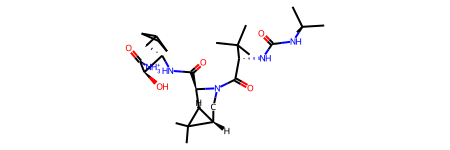

In [17]:
mol = Chem.MolFromSmiles('CC(C)(C)NC(=O)N[C@H](C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@@H](CC1CCC1)[C@@H](O)C([NH3+])=O)C2(C)C)C(C)(C)C',sanitize=True)
#mol=Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
mol

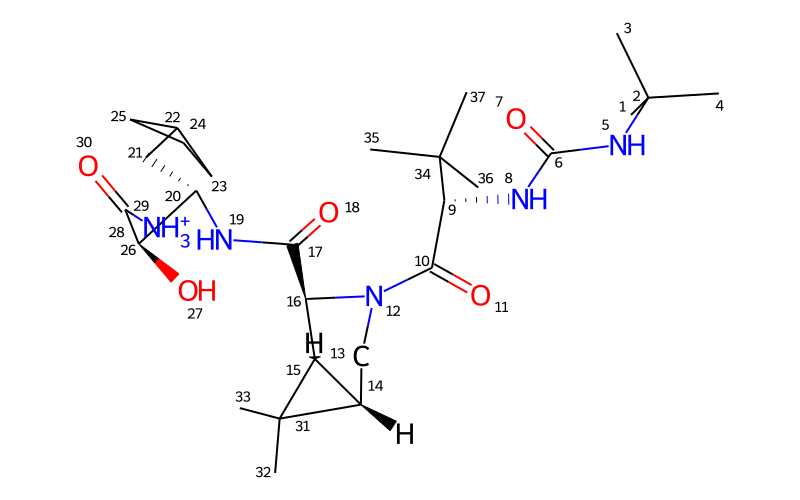

In [18]:
for atom in mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()+1))

Draw.MolToImage(mol, size=(800,500))

In [19]:
f=Chem.rdGeometry.Point3D(0,0,0)

In [20]:
list(f)

[0.0, 0.0, 0.0]

In [21]:
coors = dict()

for a,b in amap:
    coors[a] = constrain.GetConformer().GetAtomPosition(b)

w = Chem.SDWriter(output)

mol.UpdatePropertyCache()
constrain.UpdatePropertyCache()

confs = AllChem.EmbedMultipleConfs(mol,
    numConfs=int(num_confs),
    coordMap=coors,
    pruneRmsThresh=0.75,
    useExpTorsionAnglePrefs=True,
    useBasicKnowledge=True)

NameError: name 'amap' is not defined

In [22]:
with open('ddd.smiles','r') as mols:
    for line in mols.readlines():
        mol=Chem.MolFromSmiles(line)
        print(mol)

FileNotFoundError: [Errno 2] No such file or directory: 'ddd.smiles'